In [1]:
from process_data import process_data, process_data_clinical_dose, process_data_pharmacogenetic_dose
import numpy as np
import matplotlib.pyplot as plt
import pickle

path = 'data/warfarin.csv'
features, labels = process_data(path)
labels = labels -1
print(set(labels), features.shape)

{0, 1, 2} (5528, 225)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


def supervised(trail_seed):

    torch.manual_seed(trail_seed)
    
    features_copy = features.copy()
    labels_copy = labels.copy()
    np.random.seed(trail_seed)
    np.random.shuffle(features_copy)
    np.random.seed(trail_seed)
    np.random.shuffle(labels_copy)
    

    def get_data_stream(features):
        for sample in features:
            yield sample

    def get_label_stream(labels):
        for sample in labels:
            yield sample

    # Define the PyTorch model class
    class Classifier(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(Classifier, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(hidden_size, output_size)
            
        def forward(self, x):
            x = self.fc1(x)
            x = self.relu(x)
            x = self.fc2(x)
            return x


    def train(model, optimizer, criterion, data, labels):
        model.train()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        return loss.item()


    input_size = 225 
    hidden_size = 20 # Number of hidden units
    output_size = 3 
    learning_rate = 0.01

 
    model = Classifier(input_size, hidden_size, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    data_stream = get_data_stream(features_copy)
    label_stream = get_label_stream(labels_copy) 
    regret = 0.0
    regret_plot = []
    correct_plot = []
    incorrect_decisions = 0.0
    total_decisions = 0.0

    for i in tqdm(range(features.shape[0])):
        data = next(data_stream)
        label = next(label_stream)
        prediction = model(torch.tensor(data).float()).argmax().item()
            
        if prediction != label:
            if abs(prediction - label) == 1:
                regret += 3
            elif abs(prediction - label) == 2:
                regret += 6
            else:
                raise ValueError
            incorrect_decisions += 1
        total_decisions += 1
        regret_plot.append(regret/3)
        correct_plot.append(1-incorrect_decisions/total_decisions)
        loss = train(model, optimizer, criterion, torch.tensor(data).float().unsqueeze(0), torch.tensor([label]))
    return regret_plot, correct_plot


# if want 20 runs, change the fllowing line to:
trial_seed = np.random.randint(1, 100, 20)

# trial_seed = np.random.randint(1, 100, 3)
regret_list = []
correct_list = []
for i in trial_seed:
    regret_plot, correct_plot = supervised(i)
    regret_list.append(regret_plot)
    correct_list.append(correct_plot)

100%|██████████| 5528/5528 [00:02<00:00, 2271.02it/s]


In [5]:
file_name = "supervised_regret.pkl"
open_file = open(file_name, "wb")
pickle.dump(regret_list, open_file)
open_file.close()

file_name = "supervised_correct.pkl"
open_file = open(file_name, "wb")
pickle.dump(correct_list, open_file)
open_file.close()

The cell below can be used to load the list of lists:

In [169]:
file_name = "supervised_regret.pkl"
open_file = open(file_name, "rb")
loaded_regret_list = pickle.load(open_file)
open_file.close()

file_name = "supervised_correct.pkl"
open_file = open(file_name, "rb")
loaded_correct_list = pickle.load(open_file)
open_file.close()


Example to load the correct data to plot

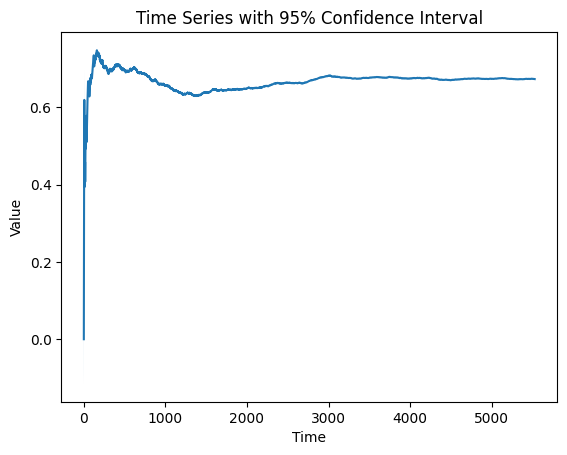

In [170]:
data = loaded_correct_list
mean = np.mean(data, axis=0)
std = np.std(data, axis=0)
N = len(data)
t = 2.093
ci_upper = mean + t * (std / np.sqrt(N))
ci_lower = mean - t * (std / np.sqrt(N))

plt.plot(mean)
plt.fill_between(range(len(mean)), ci_upper, ci_lower, alpha=.2)

plt.title("Time Series with 95% Confidence Interval")
plt.xlabel("Time")
plt.ylabel("Value")

plt.show()